## Performance test on the Olivetti Faces

In this notebook we compare the clustering performance of k-means++, HDBSCAN, Quickshift++, and CLASSIX. The Olivetti Faces dataset contains 400 images of 40 distinct faces with variations in lighting, facial expressions (e.g., smiling or not), and other facial details (e.g., wearing glasses or not). The images are resized to 100-by-100 pixels and represented as 10,000-dimensional feature vectors containing the grayscale values.

We cluster all 400 data points using the above listed methods. The hyperparameters of each method have been tuned by careful grid search. Should you find a set of parameters that improves a method significantly, please let us know and we will update this notebook.

Following the example in (Rodriguez and Laio, 2014), we select a number of faces from the dataset and visualize their cluster membership using colour coding.

In [5]:
import hdbscan
from sklearn.cluster import KMeans
from quickshift.QuickshiftPP import *
from threadpoolctl import threadpool_limits
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from classix import CLASSIX, loadData
import classix
from time import time
import pandas as pd
import numpy as np
import os, cv2
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
import collections

import pkg_resources
print("Kmeans++ version:", pkg_resources.get_distribution('scikit-learn').version)
print("HDBSCAN  version:", pkg_resources.get_distribution('hdbscan').version)
print("Quickshift++ ver: Aug 2018") # https://github.com/google/quickshift
print("CLASSIX  version:", classix.__version__)

Kmeans++ version: 1.2.1
HDBSCAN  version: 0.8.33
Quickshift++ ver: Aug 2018
CLASSIX  version: 1.0.5


In [8]:
def order_pics(figs):
    images = list()
    labels = list()
    for i in range(40):
        num = i + 1
        for img in figs:
            try:
                if int(img.split('_')[1].replace('.jpg','')) == num:
                    images.append(img)
                    labels.append(num)
            except:
                pass
    return images, labels
    
def load_images(folder, shape=(100, 100)):
    images = list()
    figs = os.listdir(folder)
    figs, targets= order_pics(figs)
    for filename in figs:
        img = cv2.imread(os.path.join(folder,filename)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        img = cv2.resize(img, shape, interpolation = cv2.INTER_AREA) # resize to 80x80
        if img is not None:
            images.append(img)
    images, targets = np.array(images), np.array(targets) - 1
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    return images, targets

lari = list()
lami = list()
runtime = list()

folder = 'OlivettiFaces'
X, y = load_images(folder)
clusterNum = len(np.unique(y))

min_cluster = min(collections.Counter(y).items(), key=lambda x: x[1])[1]

with threadpool_limits(limits=1, user_api='blas'):
    clx = CLASSIX(sorting='pca', radius=0.54, minPts=3, verbose=0, group_merging='distance')
    st = time()
    clx.fit(X)
    et = time()
    print("CLASSIX uses time:", et - st)
    print("ARI:", ari(clx.labels_, y))
    print("AMI:", ami(clx.labels_, y))
    lari.append(ari(clx.labels_, y))
    lami.append(ami(clx.labels_, y))
    runtime.append(et - st)

    _hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, algorithm='best')
    st = time()
    _hdbscan.fit(X)
    et = time()
    print("HDBSCAN uses time:", et - st)
    print("ARI:", ari(_hdbscan.labels_, y))
    print("AMI:", ami(_hdbscan.labels_, y))
    lari.append(ari(_hdbscan.labels_, y))
    lami.append(ami(_hdbscan.labels_, y))
    runtime.append(et - st)

    quicks = QuickshiftPP(k=9, beta=0.7)
    st = time()
    quicks.fit(X.copy(order='C'))
    et = time()
    print("Quickshift uses time:", et - st)
    print("ARI:", ari(quicks.memberships, y))
    print("AMI:", ami(quicks.memberships, y))
    lari.append(ari(quicks.memberships, y))
    lami.append(ami(quicks.memberships, y))
    runtime.append(et - st)

    kmeans = KMeans(n_clusters=clusterNum, init='k-means++', n_init='auto', random_state=1)
    st = time()
    kmeans.fit(X)
    et = time()
    print("kmeans uses time:", et - st)
    print("ARI:", ari(kmeans.labels_, y))
    print("AMI:", ami(kmeans.labels_, y))
    lari.append(ari(kmeans.labels_, y))
    lami.append(ami(kmeans.labels_, y))
    runtime.append(et - st)

labels_ = [clx.labels_, _hdbscan.labels_, quicks.memberships, kmeans.labels_]# , depddp_class]
lari = np.asarray(lari)
lami = np.asarray(lami)
runtime = np.asarray(runtime)
np.save("result/exp1/olivetti_ari.npy", lari)
np.save("result/exp1/olivetti_ami.npy", lami)
np.save("result/exp1/olivetti_runtime.npy", runtime)
np.save("result/exp1/olivetti_labels.npy", labels_)

CLASSIX uses time: 1.140988826751709
ARI: 0.6655494516761021
AMI: 0.839551568838854
HDBSCAN uses time: 4.290446758270264
ARI: 0.3940236570910377
AMI: 0.7273864449199154
Quickshift uses time: 4.138182640075684
ARI: 0.6588833850300853
AMI: 0.8399985246684827
kmeans uses time: 0.6330957412719727
ARI: 0.6043725906065336
AMI: 0.7644502183830783


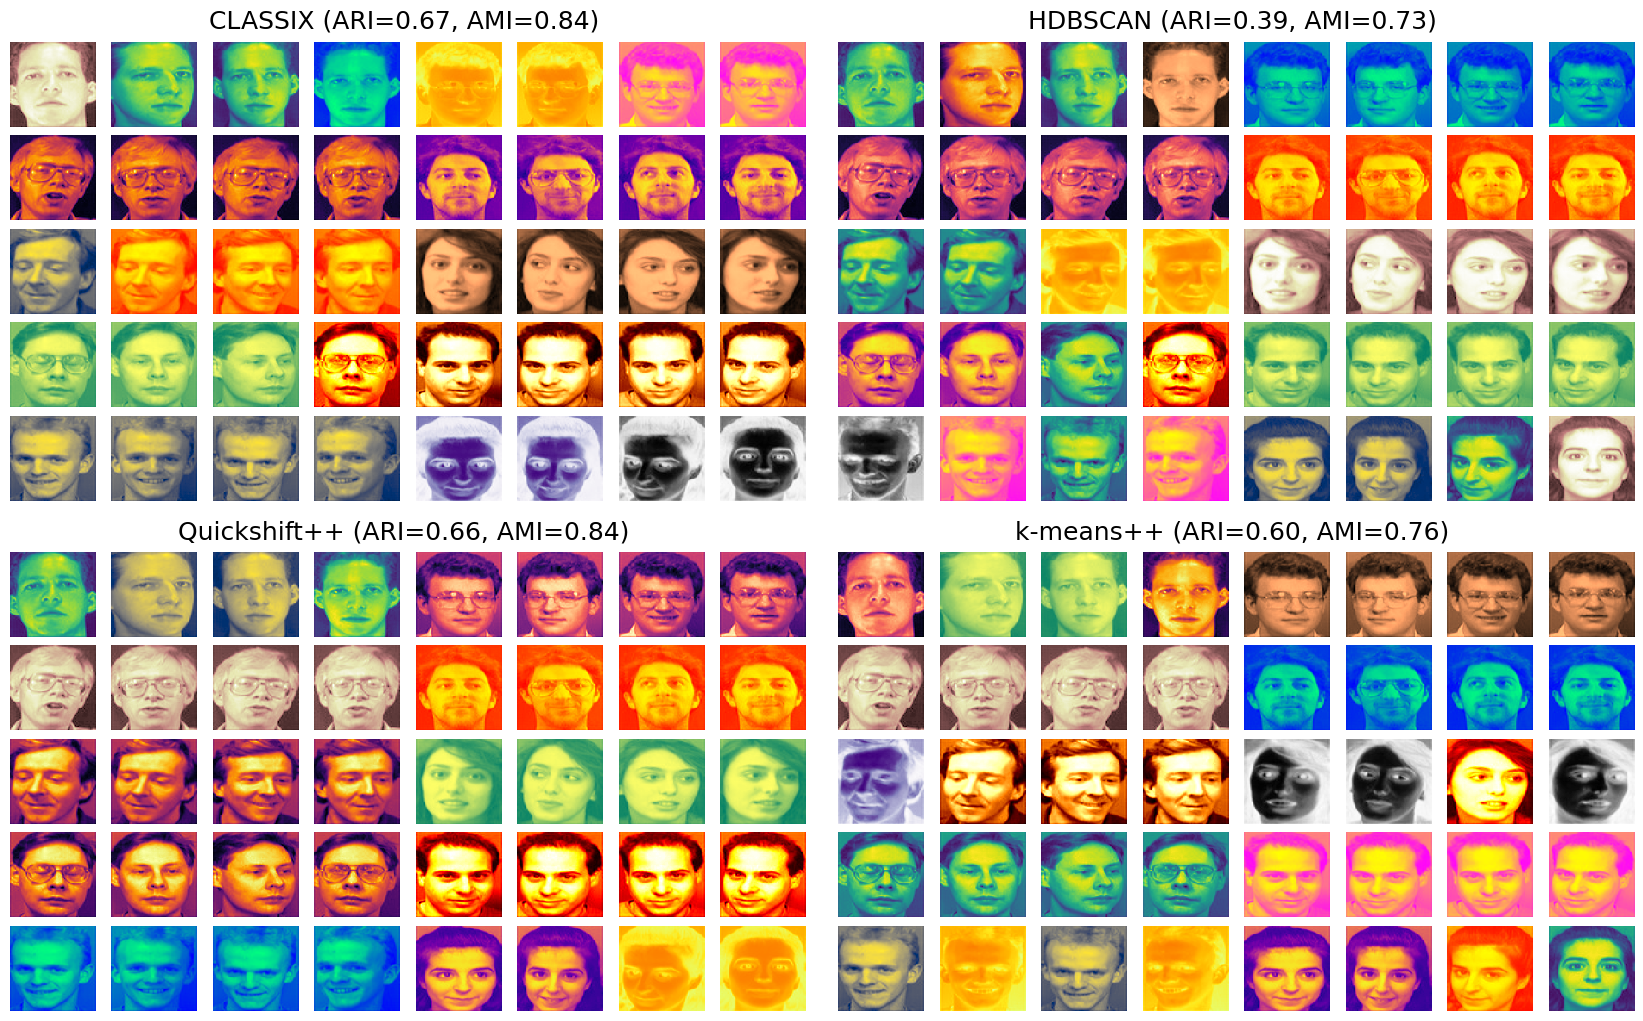

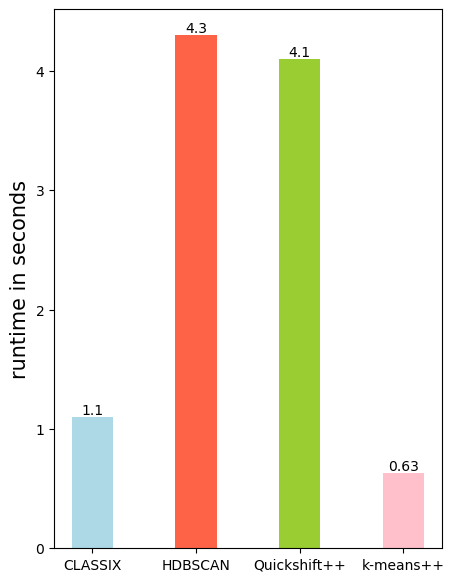

In [10]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import math

def sigificant_digit(number, digits=4):
    return round(number, digits - int(math.floor(math.log10(abs(number)))) - 1)

def order_pics(figs):
    images = list()
    labels = list()
    for i in range(40):
        num = i + 1
        for img in figs:
            try:
                if int(img.split('_')[1].replace('.jpg','')) == num:
                    images.append(img)
                    labels.append(num)
            except:
                pass
    return images, labels
    
def load_images(folder, shape=(100, 100)):
    images = list()
    figs = os.listdir(folder)
    figs, targets= order_pics(figs)
    for filename in figs:
        img = cv2.imread(os.path.join(folder,filename)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        img = cv2.resize(img, shape, interpolation = cv2.INTER_AREA) # resize to 80x80
        if img is not None:
            images.append(img)
    images, targets = np.array(images), np.array(targets) - 1
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    return images, targets

folder = 'OlivettiFaces'
X, y = load_images(folder)
clear_cmaps =  [ 'viridis', 'cividis', 'pink', 'inferno', 'winter', 
                'copper','magma', 'autumn', 'summer', 'hot', 'plasma', 'Wistia',  
                'afmhot','spring']

cmaps = OrderedDict()

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Sequential_2'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']


algorithms = ['CLASSIX', 'HDBSCAN', 'Quickshift++', 'k-means++']
lari = np.load("result/exp1/olivetti_ari.npy")
lami = np.load("result/exp1/olivetti_ami.npy")
labels = np.load("result/exp1/olivetti_labels.npy")
runtime = np.load("result/exp1/olivetti_runtime.npy")
runtime = [sigificant_digit(c, 2) for c in runtime]

cmaps_ = clear_cmaps + cmaps['Sequential'] + cmaps['Diverging'] + cmaps['Miscellaneous'] 
fig = plt.figure(constrained_layout=True, figsize=(8.2*2, 5.05*2))
subfigs = fig.subfigures(2, 2)
ii = 0

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(algorithms[ii] + ' (ARI={0:.2f}, AMI={1:.2f}) '.format(lari[ii], lami[ii]), fontsize=18)
    axs = subfig.subplots(5, 8)
    
    labels_ = list()
    for i in range(5):
        for j in range(5):
            labels_.append(labels[ii][i*10 + j])
    for i in np.arange(5, 10):
        for j in range(5):
            labels_.append(labels[ii][i*10 + j])

    unique = np.unique(labels_)
    labels_change = np.arange(len(unique))
    labels_change = dict(zip(unique, labels_change))

    image_shape = (100, 100)

    for i in range(5):
        for j in range(4):
            axs[i,j].axis("off")
            axs[i,j].imshow(X[i*10 + j].reshape(image_shape),
                   cmap=cmaps_[labels_change[labels[ii][i*10 + j]]],
                   interpolation="nearest")

            axs[i,j+4].axis("off")
            axs[i,j+4].imshow(X[(i+5)*10 + j].reshape(image_shape),
                   cmap=cmaps_[labels_change[labels[ii][(i+5)*10 + j]]],
                   interpolation="nearest")
        
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
    ii = ii + 1

plt.savefig('result/exp1/scatter_olivetti.png', bbox_inches='tight')
plt.show()

color = ['lightblue', 'tomato', 'yellowgreen', 'pink']
plt.figure(figsize=(5, 7))
plt.bar(algorithms, runtime, width=0.4, color=color)
#plt.yscale('log')
plt.ylabel('runtime in seconds', fontsize=15)
for c in plt.gca().containers:
    plt.gca().bar_label(c)
    
plt.savefig('result/exp1/bar_olivetti.png', bbox_inches='tight')
plt.show()

## Reference

[1] Rodriguez, Alex, and Alessandro Laio. "Clustering by fast search and find of density peaks." Science 344.6191 (2014): 1492--1496.